<h3>2. b LSTM på alla meningar, plocka utan hidden -> fully connected.</h3>

<p>Denna modellen är mer avancerad då den inte enbart tar ett medelvärde av de embeddings SentenceTransformer ger utan matar in dem i ett LSTM-lager.</p>

In [3]:
from sentence_transformers import SentenceTransformer, models
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

<p>Data över uttalanden:</p>

In [4]:
# The directory where data is located
data_dirs = ["test_data/22_23/"]
data = []
for data_dir in data_dirs:
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):
            with open(data_dir+file,"r") as f:
                data.append([])
                for line in f.readlines():
                    data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

<p>För varje uttalande vill vi extrahera alla paragrafer och associera dem till rätt parti.</p>

In [5]:
possible_parties = ["S","SD","M","V","C","MP","KD","L"]
party_string = "\(("+str.join("|",possible_parties)+")\)"

parties = []
sentences = []
speech_index = 0
speech_indices = []

no_match = 0
for i in range(data.shape[0]):
    line = data[i,0]
    party = "None"
    match = re.search(party_string,line)
    if match:
        party = match.group()[1:-1]
        speech = data[i,1]
        soup = BeautifulSoup(speech, 'html.parser')
        ps = soup.find_all("p")
        non_empty = 0
        for p in ps:
            text = p.get_text()
            if text != "":
                for s in re.split("\. |\! |\? ",text):
                    sentences.append(s)
                    parties.append(party)
                    non_empty += 1
        speech_indices.append(speech_index)
        speech_index += non_empty
    else:
        no_match += 1
    

parties = np.array(parties)
sentences = np.array(sentences)

In [6]:
print(parties[:100])
print(sentences[:100])
print(speech_indices[:5])

['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'C' 'C' 'C' 'C' 'C' 'C']
['Herr talman'
 'Jag måste tyvärr säga att jag tycker att ledamoten Sundin läser Tidöavtalet som fan läser Bibeln'
 'Det finns en väldigt stark ambition från Moderaterna och de samarbetspartier som har skrivit under avtalet att vi ska fortsätta just den utveckling med en god och nära vård som jag tycker att ledamoten beskriver väl'
 'Det är en ambition som vi brett över parti- och blockgränser har varit överens om'
 'Vi vill att vården ska komma närmare patienterna'
 'Vi vill att vården ska komma närmare dem som behöver vård och omsorg.'
 'Vi har viktiga satsningar i Tidöavtalet på en f

<p>Skapa embedding-modellen.</p>

In [7]:
model_name = "paraphrase-multilingual-mpnet-base-v2"
embedding_model = SentenceTransformer(model_name)

<p>Gör embeddings av paragraferna.</p>

In [8]:
sentence_embeddings = embedding_model.encode(sentences,show_progress_bar=True) #Kanske ändra maxlängd?
torch.save(sentence_embeddings, f="multilingual_22-23_sentences.pt")

Batches:   0%|          | 0/5211 [00:00<?, ?it/s]

In [13]:
sentence_embeddings = torch.load("multilingual_22-23_sentences.pt")

<p>Gör om partier till heltal.</p>

In [7]:
def parties_to_numbers(parties):
    return np.array([possible_parties.index(p) if p in possible_parties else 8 for p in parties])

parties = parties_to_numbers(parties)

unique, counts = np.unique(parties, return_counts=True)
dict(zip(unique, counts))

{0: 37300,
 1: 16845,
 2: 34138,
 3: 16971,
 4: 14196,
 5: 13801,
 6: 18552,
 7: 14930}

<p>Skapa datasetklassen</p>

In [8]:
class SpeechesDataset(Dataset):
    def __init__(self,paragraphs,parties,index_list,length):
        self.paragraphs = torch.Tensor(paragraphs).float()
        self.parties = torch.Tensor(parties).long()
        self.index_list = index_list
        self.length = length

    def __len__(self):
        assert self.paragraphs.shape[0] == self.parties.shape[0]
        return self.length
    
    # Get speech at a certain index
    def __getitem__(self, index):
        # The index list decides which paragraphs to use
        start, stop = self.index_list[index], self.index_list[index+1]
        paragraphs = self.paragraphs[start:stop]
        parties = self.parties[start]
        return paragraphs, parties

In [9]:
def collate_fn(data):
    #print([d[0] for d in data][1])
    #print([torch.flip(d[0],[0]) for d in data][1])
    input = torch.nn.utils.rnn.pad_sequence([torch.flip(d[0],[0]) for d in data], batch_first=True)
    #print(input[1])
    #print("Now try to flip again")
    #print(torch.flip(input,[1])[1])
    input = torch.flip(input,[1])
    lengths = torch.tensor([len(d[0]) for d in data])
    output = torch.tensor([d[1] for d in data])
    return (input, lengths), output

<p>Skapa klassificeringsmodellen:</p>

In [10]:
class SpeechClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_size = batch_size

    def forward(self,x):
        #x = torch.flip(x,[1])
        f, (h,c) = self.lstm(x)
        output = self.fc(h)
        return output.squeeze()


<p>Choose a certain amount of speeches for training</p>

In [11]:
train_size = 3000
val_size = 1000
test_size = 1000

In [15]:

train_stop = speech_indices[train_size]
val_stop = speech_indices[train_size+val_size]
test_stop = speech_indices[train_size+val_size+test_size]

X_train = sentence_embeddings[:train_stop]
y_train = parties[:train_stop]

X_val = sentence_embeddings[train_stop:val_stop]
y_val = parties[train_stop:val_stop]

X_test = sentence_embeddings[val_stop:test_stop]
y_test = parties[val_stop:test_stop]

train_indices = speech_indices[:train_size+1]
val_indices = speech_indices[train_size:train_size+val_size+1]
#Important! Make sure first index is 0
val_indices = [i-val_indices[0] for i in val_indices]
test_indices = speech_indices[train_size+val_size:train_size+val_size+test_size+1]
test_indices = [i-test_indices[0] for i in test_indices]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(61247, 768) (61247,) (20264, 768) (20264,) (20183, 768) (20183,)


In [16]:
# Average length of a speech
diffs = [speech_indices[k+1]-speech_indices[k] for k in range(len(speech_indices)-1)]
print(len(diffs))
print(sum(diffs)/len(diffs))

8129
20.509287735268792


In [17]:
train_set = SpeechesDataset(X_train, y_train, train_indices, train_size)
val_set = SpeechesDataset(X_val, y_val, val_indices, val_size)
test_set = SpeechesDataset(X_test, y_test, test_indices, test_size)

In [32]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=1000, collate_fn=collate_fn)

In [30]:
next(iter(train_loader))[0][0].shape

torch.Size([64, 60, 768])

<p>Initialize the model, loss function and optimizer:</p>

In [33]:
speech_classifier = SpeechClassifier(768, 64, 8, batch_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(speech_classifier.parameters(),lr=0.005)

<p>Now train the classifier:</p>

In [34]:
from tqdm import tqdm

speech_classifier.train()

train_losses = []
val_losses = []
#train_losses = torch.load("train_losses_model_2b.pt")
#val_losses = torch.load("val_losses_model_2b.pt")

#batch_size = 32
epochs = 20

for epoch in tqdm(range(epochs)):
    speech_classifier.train()
    for i, ((X_train, X_lengths), y_train) in enumerate(train_loader):
        y_pred = speech_classifier(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Evaluate
    speech_classifier.eval()
    for i, ((X_val, X_lengths), y_val) in enumerate(val_loader):
        y_pred = speech_classifier(X_val)
        loss = loss_fn(y_pred, y_val)
        val_losses.append(loss.item())
    clear_output()
    print("Train loss: "+str(train_losses[-1]))
    print("Validation loss: "+str(val_losses[-1]))
    
    

100%|██████████| 20/20 [01:35<00:00,  4.76s/it]

Train loss: 0.0783340260386467
Validation loss: 2.568347930908203


<p>Plot the losses:</p>

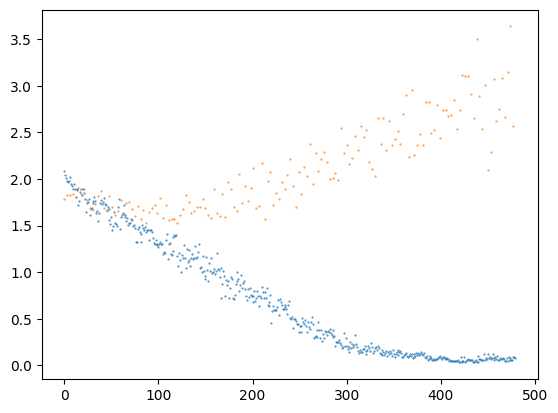

In [35]:
import matplotlib.pyplot as plt

# Save and plot losses
torch.save(train_losses,f="train_losses_model_2b.pt")
torch.save(val_losses,f="val_losses_model_2b.pt")

t1 = np.arange(len(train_losses))
t2 = train_size/val_size*np.arange(len(val_losses))
plt.scatter(t1,train_losses,s=0.2)
plt.scatter(t2,val_losses,s=0.2)
plt.show()

<p>Evaluate.</p>

In [38]:
speech_classifier.eval()
y_tests = np.array([])
y_preds = np.array([])
for i, ((X_test, X_lengths), y_test) in enumerate(train_loader):
    y_pred = speech_classifier(X_test).softmax(dim=1).argmax(dim=1)
    y_tests = np.concatenate((y_tests,y_test))
    y_preds = np.concatenate((y_preds,y_pred))
print(i)

23


In [39]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_tests,y_preds,target_names=possible_parties))

              precision    recall  f1-score   support

           S       1.00      0.99      0.99       679
          SD       1.00      1.00      1.00       304
           M       0.99      1.00      1.00       666
           V       1.00      1.00      1.00       276
           C       1.00      0.99      0.99       238
          MP       1.00      0.99      0.99       219
          KD       1.00      0.98      0.99       326
           L       0.97      1.00      0.98       292

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

